# Forecast Model

### Using Rolling Mean and Lag(delay)/shift techniques

Big Pharma is a large pharmaceutical distribution company in Germany. They restock their
warehouses monthly but have been running into issues with overstocking and under-stocking
products. You were employed as a data scientist to help find a solution to this problem. The sales
team has provided you with data to get started on implementing your solution.


**GOAL**
<hr>
the goal for this project is to build a model to forecast a month of big pharma's Stock Demand using previous records to optimize Inventory overstocking and under-stocking.

In [1]:
# import libraries
import pandas as pd 
import datetime
import numpy as np
np.random.seed(42)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error # metrics

load the excel data

In [2]:
# load the data 
df = pd.read_excel('pharmaceutical-sales-demand.xlsx',date_parser=['Date'])

In [3]:
# preview data
df.head()

,Date,Product ID,Stock Demand
0,2020-10-05,I6DO4,-1
1,2020-10-05,O40SR,16
2,2020-10-19,Y03MS,306
3,2020-10-08,B0OR2,307
4,2020-10-02,EIM03,6


get the general information of the data

In [4]:
df.info()
# from the information below we can see that we have over a million plus records

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   Date          1048575 non-null  datetime64[ns]
 1   Product ID    1048575 non-null  object        
 2   Stock Demand  1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 24.0+ MB


have a look on general statistics on this data 

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Stock Demand,1048575.0,79.705856,610.023009,-12226.0,3.0,9.0,31.0,149004.0


**from this statistics 75% of the Stock Demanded in Big Pharma lies below 31 units and max over 149,000.
this appears to be a major outlier. we will fix that in our feature engineering stage**

In [6]:
print(f"the maximum Stock Demand ever requested in the Big Pharma Data span is: {df.describe().T['max']}")

print(f"the minimum Stock Demand Date of this data is: {df.Date.min()}")

print(f"the maximum Stock Demand Date of this data is: {df.Date.max()}")

the maximum Stock Demand ever requested in the Big Pharma Data span is: Stock Demand    149004.0
Name: max, dtype: float64
the minimum Stock Demand Date of this data is: 2020-10-01 00:00:00
the maximum Stock Demand Date of this data is: 2021-07-31 00:00:00


In [7]:
df.sample(10)

,Date,Product ID,Stock Demand
781974,2021-05-04,S0E3P,10
937737,2021-06-22,2MOL0,1
907828,2021-06-18,I395R,3
784628,2021-05-24,070RI,9
662460,2021-03-10,NL0X1,453
280139,2020-12-26,EB30K,1
355572,2021-01-06,TN552,3
749979,2021-04-14,U01OR,4
374753,2021-01-13,E0TN3,5
17327,2020-10-05,NA30B,460


## Exploratory Data Analysis

<Figure size 576x432 with 0 Axes>

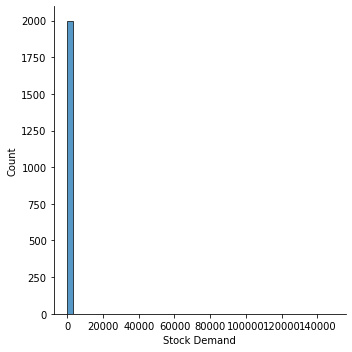

In [8]:
plt.figure(figsize=(8,6))
sns.displot(df['Stock Demand'].sample(2000), bins=40);
# seaborn will not be able to handle plotting the whole data but let's view some of it.

from the distribution plot above we can see that most of it's values are farther away from each other
in our statistics plot below we see that 50% of the values lie below 3

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Stock Demand,1048575.0,79.705856,610.023009,-12226.0,3.0,9.0,31.0,149004.0


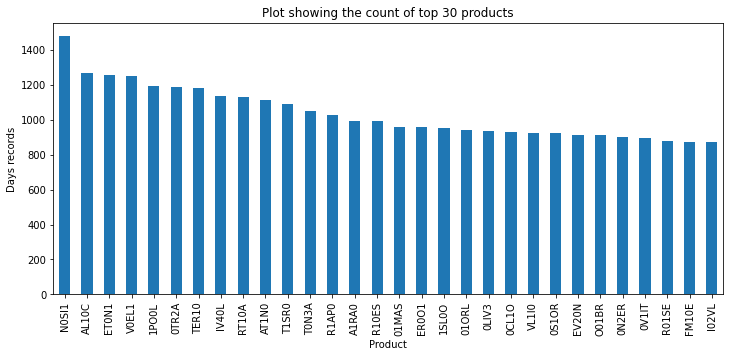

In [10]:
df['Product ID'].value_counts()[:30].plot(kind='bar', figsize=(12,5))
plt.ylabel('Days records')
plt.xlabel('Product')
plt.title("Plot showing the count of top 30 products");

let's have a sneak peak on one of the products

In [11]:
df[df['Product ID'] == 'N0SI1']

,Date,Product ID,Stock Demand
644,2020-10-12,N0SI1,16
1732,2020-10-27,N0SI1,2
1779,2020-10-14,N0SI1,81
4018,2020-10-26,N0SI1,29
4102,2020-10-10,N0SI1,4
...,...,...,...
1043673,2021-07-14,N0SI1,1
1044032,2021-07-22,N0SI1,53
1045948,2021-07-12,N0SI1,1
1046314,2021-07-10,N0SI1,1


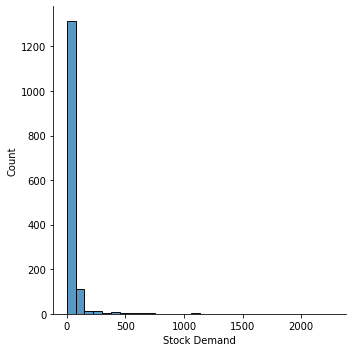

In [12]:
sns.displot(df[df['Product ID'] == 'N0SI1']['Stock Demand'],bins=30);

the stock demands for products **N0SI1** shows demands were mostly less than 500, at times there was spike in this products demand of up to 1500.

## Feature Engineering

**Let us group the the products and dates by thier stock demand sum so we can have a unique day for the various products demands.**

In [13]:
print(len(df), " before grouping.")

1048575  before grouping.


In [14]:
df = df.groupby(['Date','Product ID']).sum().reset_index()

In [15]:
print(len(df), " after grouping.")

874811  after grouping.


the data has reduced in size, so we have an unique day stocks demand for each product

In [16]:
df[df['Stock Demand'] < 0 ].head()

,Date,Product ID,Stock Demand
185,2020-10-01,0AML4,-54
186,2020-10-01,0AP5R,-1
304,2020-10-01,0FL2U,-7
515,2020-10-01,0RL1E,-4
553,2020-10-01,0TEN4,-4


In [17]:
print("number of stocks with less than or 0 values ",len(df[df['Stock Demand'] <0 ]))

number of stocks with less than or 0 values  5334


**some stocks appear to have zero values; since we do not know why these stocks have zero values we have to drop them as to avoid affect our model because we are predicting stock demand and demand cannot be negative**

In [18]:
df = df[df['Stock Demand'] > 0 ]

**there are lot's of outliers in our model, building the model with these large shooting outliers would distort our model and make it harder for thr model to learn**

In [19]:
CDI  = df[df['Product ID']== 'ZC25D'].copy()
CDI['month'] = CDI['Date'].dt.month
CDI['year'] = CDI['Date'].dt.year
CDI.groupby(['year','month'])['Stock Demand'].sum()

year  month
2020  10       18566
      11       17237
      12       17083
2021  1         5475
      2         3420
      3        15253
      4         3721
      5         1540
      6          301
      7          535
Name: Stock Demand, dtype: int64

In [20]:
del CDI

we can see for product **ZC25D** in 2021 month 6 there was a really low demand compared to the history of this product. our model can get confused if it comes out as an outlier but we will try to remove below 5% and above 95% data outliers

In [21]:
res = df.groupby("Product ID")["Stock Demand"].transform(lambda x : (x<x.quantile(0.95))&(x>(x.quantile(0.05)))).eq(1)
df = df[res]

**in predicting a months data we need enough historical data. since the data are measured in days we will use only data with at least 60 days (2month) of history so our model can try to understand the past pattern of the products demand trend.**

In [22]:
df['Product ID'] = df['Product ID'].astype(str)
df = df.groupby('Product ID').filter(lambda x: len(x) >= 60).copy()

In [23]:
print("current data size ",len(df))

current data size  637286


In [24]:
#sort the data by products and date
df.sort_values(['Product ID','Date'], inplace=True)

**We would create new features off the date columns such as the month, year and much more**

In [25]:
def create_date_features(df):
    df['month'] = df.Date.dt.month
    # month
    df['day_of_month'] = df.Date.dt.day
    # day of month
    df['day_of_year'] = df.Date.dt.dayofyear
    # day of year
    df['week_of_year'] = df.Date.dt.isocalendar().week.astype(int)
    # week of year
    df['day_of_week'] = df.Date.dt.dayofweek
    # day of week
    df['year'] = df.Date.dt.year
    # year
    df["is_wknd"] = df.Date.dt.weekday // 4
    # is weekend
    df['is_month_start'] = df.Date.dt.is_month_start.astype(int)
    # is month start
    df['is_month_end'] = df.Date.dt.is_month_end.astype(int)
    # is month end
    return df

In [26]:
# we create the features
df = create_date_features(df)
df.head()

,Date,Product ID,Stock Demand,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
3691,2020-10-02,002R2,3,10,2,276,40,4,2020,1,0,0
17169,2020-10-07,002R2,20,10,7,281,41,2,2020,0,0,0
24864,2020-10-09,002R2,4,10,9,283,41,4,2020,1,0,0
30951,2020-10-12,002R2,18,10,12,286,42,0,2020,0,0,0
35229,2020-10-13,002R2,3,10,13,287,42,1,2020,0,0,0


**Now we create the rolling features and lag(delay) shifts features.**

In [27]:
# the rolling mean feature functuon takes the dataframe and the rolling windows
# first it shifts the data by 1 then calcultates the rolling mean for the inputed window

def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['stock_D_roll_mean_' + str(window)] = dataframe.groupby(["Product ID"])['Stock Demand']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=2,win_type='triang').mean()) 
    return dataframe

# the random noise function that creates random noise of the data and adds to the roll and lag features
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

# the lag features shifts the data by the lag span inputed. it's a delay of the data from its previous records. it also adds random noise
# to prevent overfitting
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['stockD_lag_' + str(lag)] = dataframe.groupby(["Product ID"])['Stock Demand'].transform(
            lambda x: x.shift(lag)) 
    return dataframe

before we pass the data to the rolling and lagg features let's make our stock demand for the test set np.nan so we do not have a data leakage in the training set. later on we will do the main splitting. tho we know where our split begins so we will save the y test values

In [28]:
y_test = df[df.Date >= pd.Timestamp('2021-07-01')]['Stock Demand'].copy() 
y_test = y_test.values

# make the y test set part(stock data) of the main data np.nan so our lag and rolling mean doesnt use the features
df.loc[df.Date >= pd.Timestamp('2021-07-01') , 'Stock Demand'] = np.nan

In [29]:
#df.loc[df.Date >= pd.Timestamp('2021-07-01')]['Stock Demand']

In [30]:
# rolling mean and lag features
df = roll_mean_features(df,[2,3,4,15,30])#2,3,4 180
df = lag_features(df,[15,21,30,50,60,90])#,90,180

In [31]:
# data information after rolling mean and lag features have been added
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 637286 entries, 3691 to 871021
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  637286 non-null  datetime64[ns]
 1   Product ID            637286 non-null  object        
 2   Stock Demand          609499 non-null  float64       
 3   month                 637286 non-null  int64         
 4   day_of_month          637286 non-null  int64         
 5   day_of_year           637286 non-null  int64         
 6   week_of_year          637286 non-null  int64         
 7   day_of_week           637286 non-null  int64         
 8   year                  637286 non-null  int64         
 9   is_wknd               637286 non-null  int64         
 10  is_month_start        637286 non-null  int64         
 11  is_month_end          637286 non-null  int64         
 12  stock_D_roll_mean_2   605228 non-null  float64       
 

In [32]:
df.head()

,Date,Product ID,Stock Demand,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,...,stock_D_roll_mean_3,stock_D_roll_mean_4,stock_D_roll_mean_15,stock_D_roll_mean_30,stockD_lag_15,stockD_lag_21,stockD_lag_30,stockD_lag_50,stockD_lag_60,stockD_lag_90
3691,2020-10-02,002R2,3.0,10,2,276,40,4,2020,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17169,2020-10-07,002R2,20.0,10,7,281,41,2,2020,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24864,2020-10-09,002R2,4.0,10,9,283,41,4,2020,1,...,8.666667,7.250000,8.666667,7.250000,NaN,NaN,NaN,NaN,NaN,NaN
30951,2020-10-12,002R2,18.0,10,12,286,42,0,2020,0,...,11.750000,10.428571,8.833333,8.777778,NaN,NaN,NaN,NaN,NaN,NaN
35229,2020-10-13,002R2,3.0,10,13,287,42,1,2020,0,...,11.500000,11.625000,9.800000,9.437500,NaN,NaN,NaN,NaN,NaN,NaN


### Splitting Data; train and test split

we will split the data into train and test set. 
<br>
our test set is the last known month of this data which is august(07)

In [33]:
df.loc[df.Date >= pd.Timestamp('2021-07-01') , 'Stock Demand'] = y_test
del y_test

# the train data
train = df[df.Date < pd.Timestamp('2021-07-01')].copy()
# the test data, which is the last month
test = df[df.Date >= pd.Timestamp('2021-07-01')].copy()

here we remove product ID that are in the test set but were not in the training set.
we will use a test data with product ID that must have appeared in our training data as to not confuse the model.

In [34]:
ids = train['Product ID'].unique()
ids = ids.tolist()
test = test[test['Product ID'].isin(ids)]

In [35]:
# shape of train and test data
print(train.shape)
print(test.shape)

(609499, 23)
(27787, 23)


### Model Building

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

seperate the target variable and independent variables

In [37]:
X_train = train.drop(['Stock Demand','Date'],axis=1)
y_train = train['Stock Demand']
y_train = np.log1p(y_train.values) # scale the target feature to reduce the dispersion of the data

X_test = test.drop(['Stock Demand','Date'],axis=1)
y_test = test['Stock Demand'] 
y_test = np.log1p(y_test.values) # we have taken our y_test feature above you can scroll the notebook 

#### Build the pipeline

In [38]:
OHE = OneHotEncoder(drop='first')# we will encode the Product ID column
scaler = MinMaxScaler() # we will scale the other numeric columns

num_cols =X_train.columns[1:] # the numerical columns'
#num_cols.extend(cols)
cat_cols = ['Product ID'] # cat column

transformer = ColumnTransformer([('cat_cols', OHE, cat_cols),
                                ('num_cols', scaler, num_cols)])

# XGB model
xg_reg = xgb.XGBRegressor(random_state=42)

# the pipeline
pipeT = Pipeline([("preprocessing", transformer),
                    ("model",xg_reg)])

**fit pipeline to training data**

In [39]:
pipeT.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(drop='first'),
                                                  ['Product ID']),
                                                 ('num_cols', MinMaxScaler(),
                                                  Index(['month', 'day_of_month', 'day_of_year', 'week_of_year', 'day_of_week',
       'year', 'is_wknd', 'is_month_start', 'is_month_end',
       'stock_D_roll_mean_2', 'stock_D_roll_mean_3', 'stock_D_roll_mean_4',
       'stock_D_roll_m...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=42, reg_alpha=0,
                              reg_lambda=1, ...))])

In [40]:
#X_train = pipeT.transform(X_train)
#X_test  = pipeT.transform(X_test)

In [41]:
# Run XGB 
#xg_red = xgb.XGBRegressor(random_state=42)

In [42]:
#xg_red.fit(X_train,y_train)

**get prediction on test data**

In [43]:
pred = pipeT.predict(X_test)

y_test = np.expm1(y_test)  # reverse of the log1p
pred = np.round(np.expm1(pred)) # reverse the log1p on prediction cos the model learnt on the log1p scale

In [44]:
evalua = test[['Product ID','month','year','Stock Demand']].copy()
evalua['Stock Demand'] =y_test.astype(int)
evalua['pred'] = pred.astype(int)

In [45]:
eval_df_monthly = evalua.groupby(['Product ID','month','year']).sum()

In [46]:
eval_df_monthly[:20].style.background_gradient(cmap='summer')

,,,Stock Demand,pred
Product ID,month,year,,
002R2,7,2021,54,58
004IV,7,2021,1683,516
00C9A,7,2021,6,14
00X32,7,2021,77,57
011ER,7,2021,42506,26842
013U2,7,2021,97,70
019CE,7,2021,21,24
01ACU,7,2021,368,265
01ADV,7,2021,88,80


In [47]:
eval_df_monthly[-20:].style.background_gradient(cmap='summer')

,,,Stock Demand,pred
Product ID,month,year,,
Z6D0R,7,2021,7,18
Z6D7R,7,2021,7,14
ZA10R,7,2021,1469,2580
ZAD10,7,2021,454,199
ZC25D,7,2021,529,69
ZD02E,7,2021,37,32
ZD2R7,7,2021,38,53
ZD4A0,7,2021,26,27
ZD4R5,7,2021,36,41


In [48]:
df[df['Product ID'] =='011ER']['Stock Demand']

3         1926.0
3693      1276.0
9224      2184.0
13319     1825.0
17173     2555.0
           ...  
858594    4790.0
865915    4512.0
867728    1339.0
871025    3815.0
872683    1821.0
Name: Stock Demand, Length: 198, dtype: float64

Text(0.5, 1.0, 'Prediction for 011ER next month Demand')

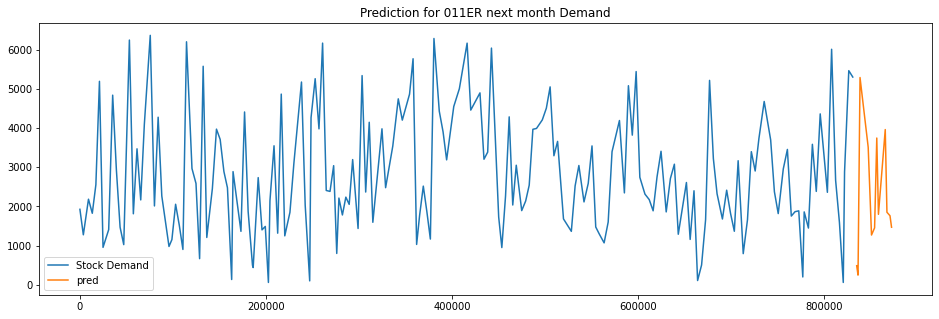

In [49]:
train[train['Product ID'] =='011ER']['Stock Demand'].plot(figsize=(16,5))
evalua[evalua['Product ID'] =='011ER']['pred'].plot(figsize=(16,5))
#evalua[evalua['Product ID'] =='011ER']['Stock Demand'].plot(figsize=(16,5))
plt.legend()
plt.title('Prediction for 011ER next month Demand')

In [50]:
r2_score(y_test,pred)

0.2067375940667806

In [51]:
mean_squared_error(y_test,pred)

74489.68197358475

**Evaluation**
we would evaluate our model using the Mean absolute percentage error

In [52]:
eval_df_monthly_stock = eval_df_monthly.reset_index()['Stock Demand']
eval_df_monthly_pred = eval_df_monthly.reset_index()['pred']

In [53]:
mean_absolute_percentage_error(eval_df_monthly_stock,eval_df_monthly_pred)

0.6102089932376675

Text(0.5, 1.0, 'monthly forecast of products for august 2021')

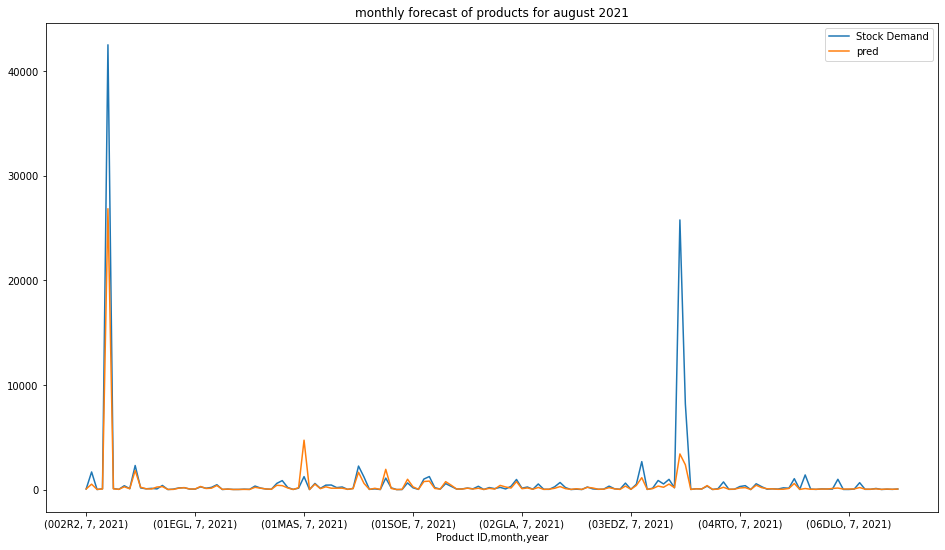

In [54]:
eval_df_monthly[:150].plot(figsize=(16,9))
plt.title("monthly forecast of products for august 2021")

Text(0.5, 1.0, 'monthly forecast of products for august 2021')

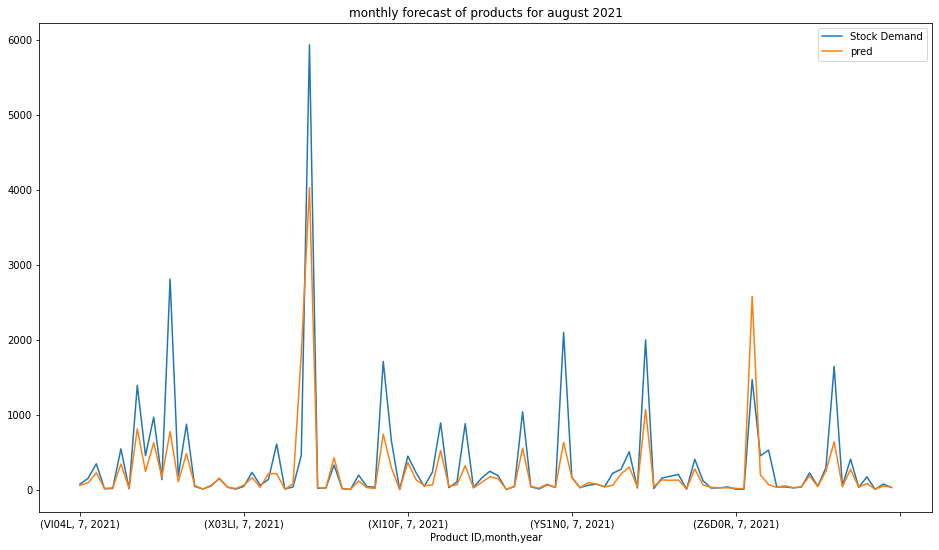

In [55]:
eval_df_monthly[-100:].plot(figsize=(16,9));
plt.title("monthly forecast of products for august 2021")

#### How will i build a pipeline for deployment ?

To build a pipeline to predict future month; we will build two pipelines. one for processing our unseen data and the other for predicting.
<br>

**new Data Processing Data Pipeline**
<br>
the first pipeline will process the unseen data. it will take the training's data record which it has stored somewhere and get the rolling mean and lag features for the unseen data.
<br>
after we have gotten this features to predict the days span which we inputed, it will then take ths data and feed it to our predicting pipeline that will fit it to the model transforming stage and predicting stage.

**Transforming and Prediction Pipeline**
<br>
this pipeline will basically take the data generated from the preprocessing pipeline and encode and scale it and feed it to the predictor model and give us and output.